## 📂 Chargement du dataset nettoyé
Nous chargeons le dataset final nettoyé (`final_clean_dataset.csv`) pour appliquer les techniques d’ingénierie des variables.

In [2]:
import pandas as pd

# Chargement du dataset
df = pd.read_csv("../datasets/final_clean_dataset.csv")

# Vérification rapide
df.shape, df.head(3)

((1042, 242),
    bind  CertControlStore  CertOpenStore  closesocket  CoCreateInstance  \
 0     0                 0              0            0                 0   
 1     0                 0              0            0                 0   
 2     0                13             56            0                 0   
 
    CoCreateInstanceEx  CoGetClassObject  CoInitializeEx  CoInitializeSecurity  \
 0                   0                 0               1                     0   
 1                   0                 0               0                     0   
 2                   3                 0              28                     2   
 
    connect  ...  \
 0        0  ...   
 1        0  ...   
 2        0  ...   
 
    HKEY_CURRENT_USER\Software\Microsoft\Windows\CurrentVersion\Internet Settings\  \
 0                                                  0                                
 1                                                  0                                
 2        

## 🔗 Suppression des variables fortement corrélées
Nous identifions les paires de variables ayant une corrélation supérieure à 0.95, et nous supprimons l’une d’entre elles pour éviter la redondance.

In [3]:
import numpy as np

# Ne pas inclure la variable cible
X = df.drop(columns="Label")

# Matrice de corrélation absolue
corr_matrix = X.corr().abs()

# Masque supérieur de la matrice
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)

# Trouver les colonnes avec corrélation > 0.95
cols_to_drop = [column for column in upper_corr.columns if any(upper_corr[column] > 0.95)]

print(f"{len(cols_to_drop)} colonnes supprimées car trop corrélées.")
df.drop(columns=cols_to_drop, inplace=True)

32 colonnes supprimées car trop corrélées.


## 📏 Dimensions finales après suppression de redondances
Nous vérifions combien de colonnes restent dans le dataset après avoir supprimé les redondances.

In [4]:
print("Dimensions du dataset :", df.shape)

Dimensions du dataset : (1042, 210)


## 📐 Standardisation des variables
Nous appliquons un standard scaler pour centrer et réduire toutes les features du dataset, sauf la variable cible.

In [5]:
from sklearn.preprocessing import StandardScaler

# Séparation features / cible
X = df.drop(columns="Label")
y = df["Label"]

# Application du scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Conversion en DataFrame pour lisibilité
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Vérification rapide
X_scaled_df.describe().T[['mean', 'std']].head()

,mean,std
bind,1.363806e-17,1.00048
CertControlStore,2.045708e-17,1.00048
CertOpenStore,0.000000e+00,1.00048
CoCreateInstance,2.727611e-17,1.00048
CoCreateInstanceEx,6.819028e-18,1.00048


## 🧬 Réduction de dimension avec PCA
Nous appliquons l’Analyse en Composantes Principales (PCA) pour identifier combien de dimensions sont réellement nécessaires pour représenter les données sans perte majeure d’information.

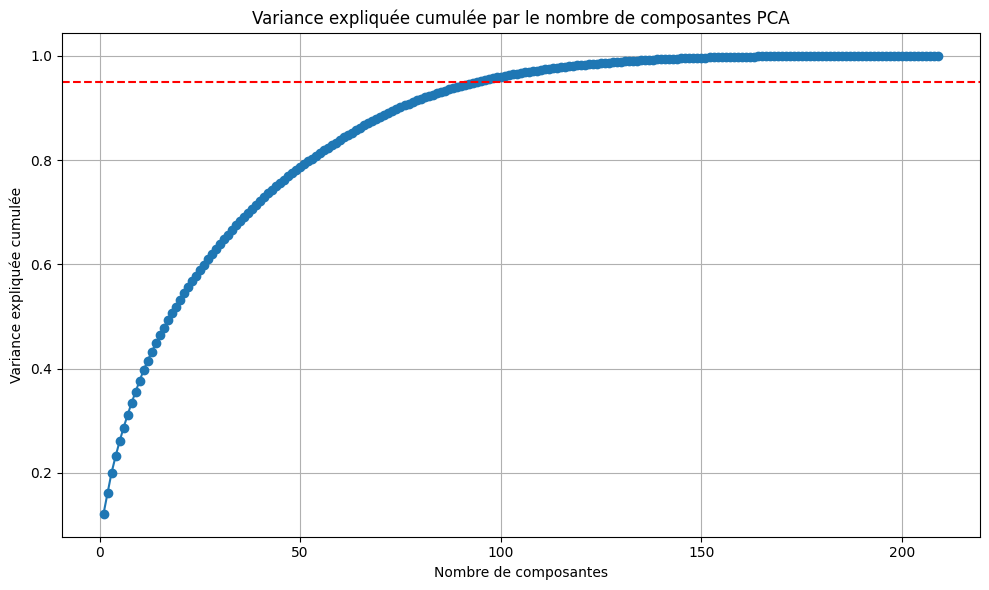

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Appliquer PCA sans réduction immédiate pour tout voir
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("Variance expliquée cumulée par le nombre de composantes PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.tight_layout()
plt.savefig("../visuals/pca_variance_cumulee.png", dpi=300)
plt.show()

## 💡 Réduction à 95 composantes principales (PCA)
Nous réduisons le dataset à 95 dimensions tout en conservant 95 % de la variance initiale. Ce nouveau dataset servira à l’entraînement des modèles.

In [8]:
# Réduire à 95 dimensions
pca_final = PCA(n_components=95, random_state=42)
X_reduced = pca_final.fit_transform(X_scaled)

# Vérification des dimensions
print("Dimensions du dataset réduit :", X_reduced.shape)

Dimensions du dataset réduit : (1042, 95)


## 💾 Sauvegarde des datasets transformés
Nous enregistrons :
- Le dataset standardisé (`X_scaled`)
- Le dataset réduit via PCA (`X_reduced`)
- Le vecteur des étiquettes (`y`)

Ils seront utilisés pour entraîner et comparer plusieurs modèles dans la phase suivante.

In [9]:
import numpy as np

# Dataset standardisé complet
X_scaled_df.to_csv("../datasets/full_scaled.csv", index=False)

# Dataset réduit par PCA
pd.DataFrame(X_reduced).to_csv("../datasets/pca_95.csv", index=False)

# Vecteur des étiquettes
y.to_csv("../datasets/labels.csv", index=False)

print("✅ Sauvegardes terminées.")

✅ Sauvegardes terminées.


## 🌲 Sélection de variables par Random Forest (méthode intégrée)
Nous utilisons un classifieur Random Forest pour identifier les variables les plus importantes, directement apprises par le modèle.

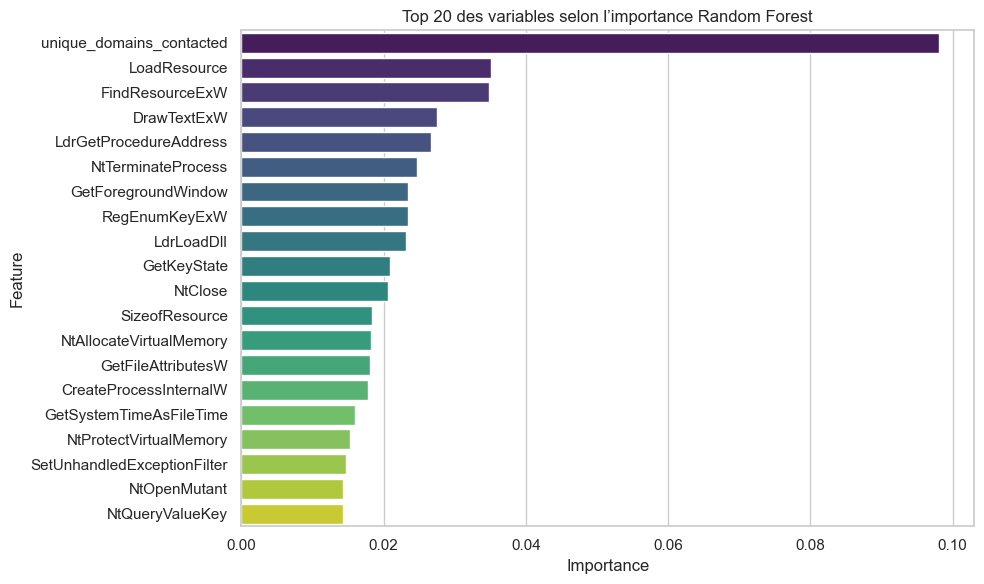

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

# Style Seaborn
sns.set(style="whitegrid")

# Réentraîner un modèle sur le dataset standardisé complet
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Récupérer l’importance des features
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisation des 20 plus importantes
plt.figure(figsize=(10,6))
sns.barplot(
    data=importance_df.head(20),
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title("Top 20 des variables selon l’importance Random Forest")
plt.tight_layout()
plt.savefig("../visuals/top20_rf_importance.png", dpi=300)
plt.show()

## 🧩 Sélection finale des variables importantes (RF ≥ 0.01)
Nous créons un sous-dataset contenant uniquement les features les plus importantes selon Random Forest, avec un seuil ≥ 0.01.


In [11]:
# Seuil d’importance minimale
threshold = 0.01
important_features = importance_df[importance_df['Importance'] >= threshold]['Feature']

# Création du dataset réduit
X_rf_selected = X_scaled_df[important_features]

print(f"{len(important_features)} features conservées (≥ {threshold})")

# Sauvegarde
X_rf_selected.to_csv("../datasets/rf_selected.csv", index=False)

31 features conservées (≥ 0.01)


## 📥 Chargement des données standardisées
Nous utilisons le dataset `full_scaled.csv` comme entrée de l’autoencoder.

In [12]:
# Charger les features standardisées
X_scaled = pd.read_csv("../datasets/full_scaled.csv")
y = pd.read_csv("../datasets/labels.csv").squeeze()

print("Shape X:", X_scaled.shape)
print("Shape y:", y.shape)

Shape X: (1042, 209)
Shape y: (1042,)


## 🧠 Autoencoder 2D – Réduction non-linéaire pour visualisation
Nous construisons un autoencoder simple qui encode les données en 2 dimensions latentes. Objectif : observer si le réseau parvient à séparer automatiquement les Ransomwares (1) et Goodwares (0).


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Dimensions
input_dim = X_scaled.shape[1]

# Architecture de l'autoencoder 2D
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck = Dense(2, activation='linear', name='bottleneck')(encoded)

decoded = Dense(64, activation='relu')(bottleneck)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=bottleneck)

# Compilation et entraînement
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Encodage
X_encoded_2D = encoder.predict(X_scaled)
X_encoded_df = pd.DataFrame(X_encoded_2D, columns=["Z1", "Z2"])
X_encoded_df["Label"] = y.values




33/33 [==============================] - 0s 789us/step


## 🌀 Visualisation 2D de la représentation latente (Autoencoder)
Nous visualisons les points projetés dans l’espace 2D latent appris par l’autoencoder. Chaque point correspond à un échantillon, coloré par sa classe (R ou G).

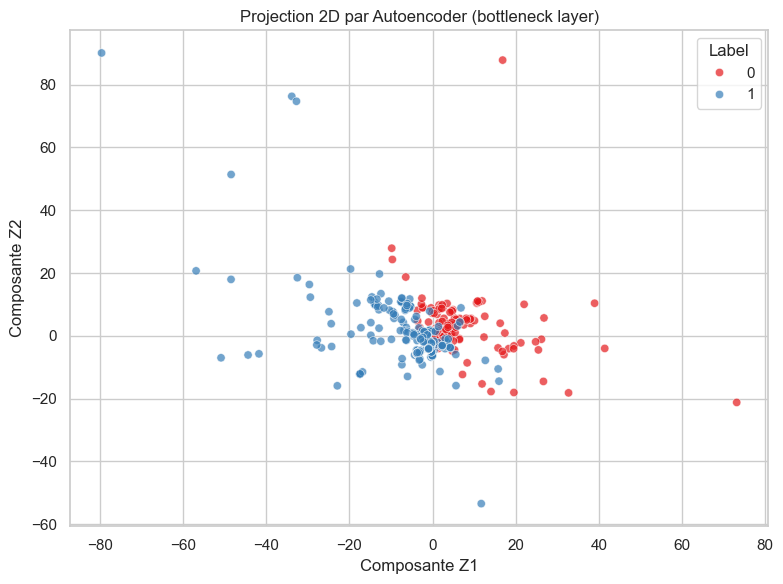

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=X_encoded_df, x="Z1", y="Z2", hue="Label", palette="Set1", alpha=0.7)
plt.title("Projection 2D par Autoencoder (bottleneck layer)")
plt.xlabel("Composante Z1")
plt.ylabel("Composante Z2")
plt.legend(title="Label", loc='best')
plt.tight_layout()
plt.savefig("../visuals/autoencoder_2D_projection.png", dpi=300)
plt.show()

## 🔧 Autoencoder 5D – Réduction non-linéaire pour modélisation
Nous utilisons un autoencoder similaire, mais avec une couche latente de 5 dimensions. L'objectif est de compresser les données en un vecteur dense utilisable directement dans un classifieur (Random Forest, SVM, MLP...).

In [ ]:
# Architecture
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
bottleneck_5D = Dense(5, activation='linear', name='bottleneck_5D')(encoded)

decoded = Dense(64, activation='relu')(bottleneck_5D)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder_5D = Model(inputs=input_layer, outputs=output_layer)
encoder_5D = Model(inputs=input_layer, outputs=bottleneck_5D)

# Compilation + entraînement
autoencoder_5D.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history_5D = autoencoder_5D.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Encodage final
X_encoded_5D = encoder_5D.predict(X_scaled)
X_encoded_5D_df = pd.DataFrame(X_encoded_5D, columns=[f"Z{i}" for i in range(1, 6)])

# Sauvegarde
X_encoded_5D_df.to_csv("../datasets/autoencoded_5D.csv", index=False)
print("✅ Dataset 5D sauvegardé :", X_encoded_5D_df.shape)

33/33 [==============================] - 0s 816us/step
✅ Dataset 5D sauvegardé : (1042, 5)


## ℹ️ Sélection de variables par Information Mutuelle
Nous mesurons la quantité d’information que chaque variable apporte à la prédiction de la classe (Goodware vs Ransomware), en utilisant la Mutual Information. Cela complète les méthodes précédentes (Random Forest, ANOVA).

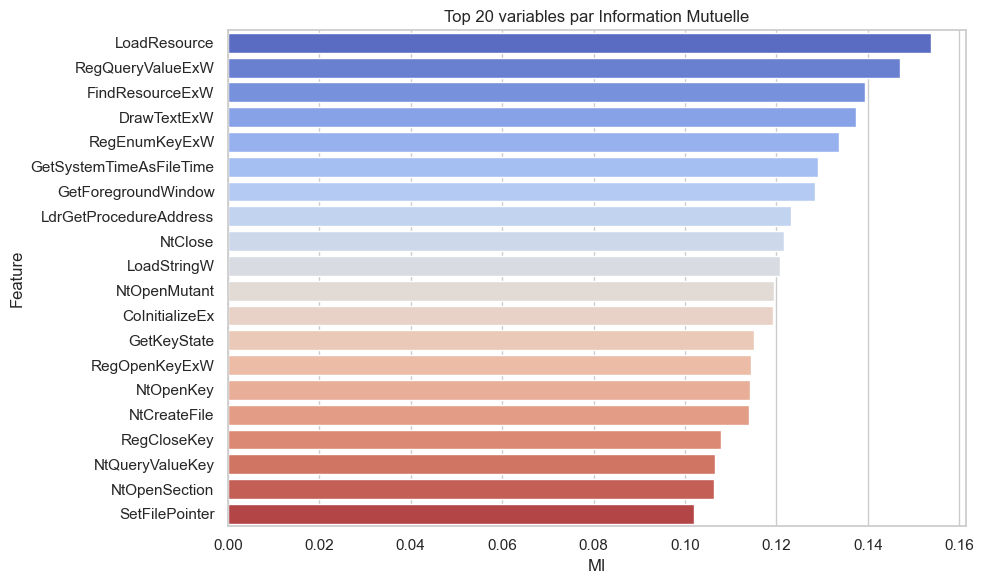

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Calcul de la mutual information
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X_scaled.columns, 'MI': mi_scores})
mi_df = mi_df.sort_values(by='MI', ascending=False)

# Visualisation des 20 meilleures variables
plt.figure(figsize=(10,6))
sns.barplot(
    data=mi_df.head(20),
    x='MI',
    y='Feature',
    hue='Feature',
    palette='coolwarm',
    legend=False
)
plt.title("Top 20 variables par Information Mutuelle")
plt.tight_layout()
plt.savefig("../visuals/top20_mutual_information.png", dpi=300)
plt.show()